In [1]:
from pathlib import Path
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
from torchinfo import summary
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

d:\anaconda3\envs\butterfly\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting up the hyperparameters
IMAGE_SIZE = 224 # 224 refers to 224 height X 224 width
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32


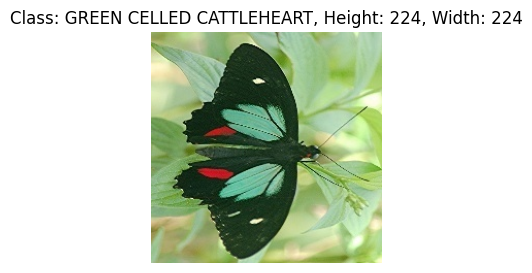

In [3]:
IMAGE_PATH = '../artifacts/data_preparation/train'
RANDOM_IMAGE_PATH = []

# Checking how many images we have in each food class
dataset_folder = os.listdir(IMAGE_PATH)

# Selecting any random image path
random_image_section = random.choice(dataset_folder)
random_image = os.path.join(IMAGE_PATH, random_image_section, 
                            random.choice(os.listdir(os.path.join(IMAGE_PATH, random_image_section))))

image = Image.open(Path(random_image))

# Display the image
plt.figure(figsize=(3, 3))
plt.title(f'Class: {random_image_section}, Height: {image.height}, Width: {image.width}')
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels if you prefer
plt.show()

In [4]:
# Function to transform the image and plot it
def transformed_image(image_path, transform, sample_size, random_state=42):
  # Setup seed
  torch.manual_seed(random_state)

  food_images = os.listdir(image_path)

  # Select random sample of images
  sample_image = random.sample(food_images, k=sample_size)

  for image in sample_image:
    with Image.open(os.path.join(image_path, image)) as f:
      plt.figure(figsize=(10, 8))
      fig, ax = plt.subplots(1, 2)

      # Visualize the original image
      ax[0].imshow(f)
      ax[0].set_title(f"Original size: {f.size}")
      ax[0].axis("off")

      # Visualize the transformed image
      # Transform the image and change the shape from (C, H, W) -> (H, W, C) using permute
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed size:\n {transformed_image.shape}")
      ax[1].axis("off")

    plt.suptitle(f"Class: {image_path.split('/')[-1]}")
    plt.show()

In [5]:
transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1000x800 with 0 Axes>

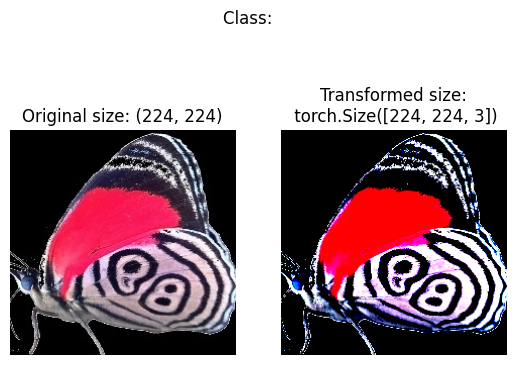

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1000x800 with 0 Axes>

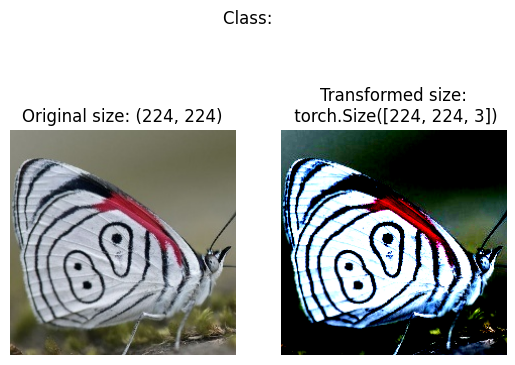

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1000x800 with 0 Axes>

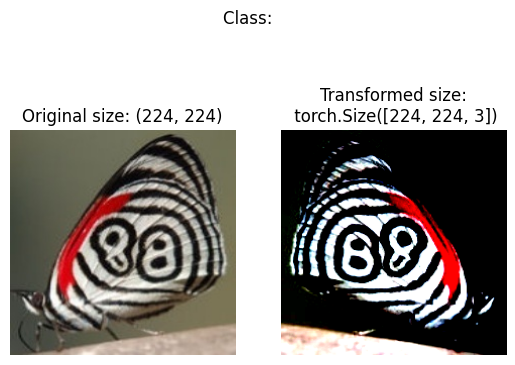

In [6]:
TRAIN_DATASET_PATH = '../artifacts/data_preparation/train/AN 88/'
transformed_image(TRAIN_DATASET_PATH, transform=transform, sample_size=3)

In [7]:
def create_data_loader(train_data_path: Path, 
                       validation_data_path: Path, 
                       transform: transforms.Compose, 
                       batch_size: int, 
                       num_workers: int) -> tuple:
    '''
    Create data loaders for training and validation datasets.

    Parameters:
        train_data_path (Path): Path to the training dataset.
        validation_data_path (Path): Path to the validation dataset.
        transform (transforms.Compose): Data transformation to be applied on the images.

    Returns:
        tuple: A tuple containing training DataLoader, validation DataLoader, and list of class names.
    '''
    # Creating ImageFolder datasets for training and validation
    train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform, target_transform=None)
    validation_dataset = datasets.ImageFolder(root=validation_data_path, transform=transform)

    # Creating DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Extracting class names from the training dataset
    class_names = train_dataset.classes

    return train_dataloader, validation_dataloader, class_names

In [10]:
# Converting to train and validation to data loaders
train_image_dir = Path('../artifacts/data_preparation/train')
validation_image_dir = Path('../artifacts/data_preparation/validation')

train_dataloader, validation_dataloader, class_names = create_data_loader(train_data_path=train_image_dir, 
                                                                          validation_data_path=validation_image_dir, 
                                                                          transform=transform, 
                                                                          batch_size=BATCH_SIZE,
                                                                          num_workers=NUM_WORKERS)

In [14]:
image, label = next(iter(train_dataloader))
image.shape, len(label)

(torch.Size([32, 3, 224, 224]), 32)